In [1]:
# So since we have known that the multivariate regression is nothing more that multiple regression, 
# then the correlation or any non-linear relation between those are not taken into account, it is
# natural to use the neural network - deep learning

## Load the library: 

from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the data: 
context = '10000_20_10_5'
fold = 0
context2 = context + '_' + str(fold)
X = np.load('data/spd2spd/X_'+context2+'.npy')
Y = np.load('data/spd2spd/Y_'+context2+'.npy')
Xt = np.load('data/spd2spd/Xt_'+context2+'.npy')
Yt = np.load('data/spd2spd/Yt_'+context2+'.npy')

2023-03-27 20:32:49.813239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 20:32:49.960754: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 20:32:49.982482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 20:32:49.982503: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
# %load 'model_creation.py'
from tensorflow import keras
from keras import backend as K
from keras import layers
from KrausLayer import KrausLayer

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)

def create_mvl_model(input_shape, output_shape):
    model: keras.Sequential = keras.models.Sequential()
    if len(input_shape) > 1:
        model.add(layers.Flatten(input_shape=[20,20]))
    else:
        model.add(layers.Input(input_shape))
    model.add(layers.Dense(output_shape))
    model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())
    return model

def create_rr_model(input_shape, output_shape, rank):
    model: keras.Sequential = keras.Sequential()
    if len(input_shape) > 1:
        model.add(layers.Flatten(input_shape=input_shape))
    else:
        model.add(layers.Input(input_shape))
    model.add(layers.Dense(units = rank))
    model.add(layers.Dense(units = output_shape))
    model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())
    return model

def create_trace_model(input_shape, rank):
    model = keras.Sequential()
    model.add(KrausLayer(1, rank, input_shape=input_shape))
    model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(0.001))

    return model

In [3]:
skip_training = False
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Multivariate Regression
 Implement by Keras and sklearn

Epoch 1/30


2023-03-24 11:51:57.566289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-24 11:51:57.566312: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-24 11:51:57.566332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hieunguyen-NUC12WSKi5): /proc/driver/nvidia/version does not exist
2023-03-24 11:51:57.566573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


313/313 [==============================] - 1s 1ms/step - loss: 934.2587 - val_loss: 268.2613
Epoch 2/30
313/313 [==============================] - 0s 950us/step - loss: 111.7744 - val_loss: 43.8066
Epoch 3/30
313/313 [==============================] - 0s 962us/step - loss: 28.5343 - val_loss: 21.1995
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 16.0560 - val_loss: 12.9587
Epoch 5/30
313/313 [==============================] - 0s 963us/step - loss: 9.9833 - val_loss: 8.2942
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 6.6124 - val_loss: 5.7517
Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 4.8239 - val_loss: 4.4016
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - loss: 3.8822 - val_loss: 3.6704
Epoch 9/30
313/313 [==============================] - 0s 803us/step - loss: 3.3399 - val_loss: 3.2037
Epoch 10/30
313/313 [==============================] - 0s 1ms/step - loss: 2.9643 - val_loss

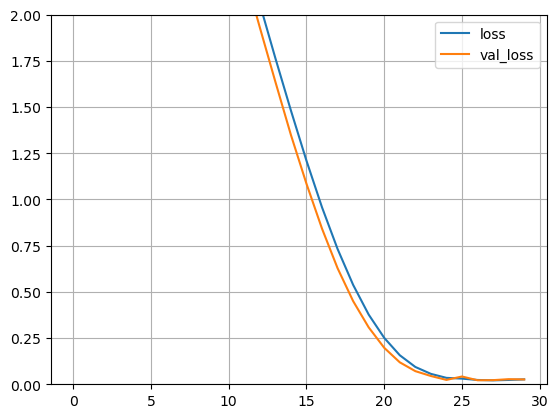

In [4]:
if not skip_training:
   model = create_mvl_model([20,20], 100)
   history = model.fit(X, Y.reshape(10000, -1), epochs=30, 
                    validation_data=(Xt, Yt.reshape(1000, -1)), callbacks=[early_stop])

pd.DataFrame(history.history).plot(title= 'Multivariate Regression')
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show() 

Optimize analyticaly with sklearn

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# X_mean = X - X.mean(axis = 0)
# Y_mean = Y - Y.mean(axis = 0)

vecX = X.reshape(X.shape[0], -1)
vecY = Y.reshape(Y.shape[0], -1)

# Xt_mean = Xt.mean(axis = 0)
# Yt_mean = Yt.mean(axis = 0)

vecXt = Xt.reshape(Xt.shape[0], -1)
vecYt = Yt.reshape(Yt.shape[0], -1)

model = LinearRegression()

model.fit(vecX, vecY)

vecY_pred = model.predict(vecXt)

mse = mean_squared_error(vecYt, vecY_pred)
print(mse )

3.9672114e-09


# Reduce rank optimization

In [4]:

# Train the model

if not skip_training:
    model = create_rr_model([20,20], 100, 50)
    history = model.fit(X, Y.reshape(10000, -1), epochs=1000, 
                        validation_data=(Xt, Yt.reshape(1000, -1)), callbacks=[early_stop])

# Plot the training curve.
    
pd.DataFrame(history.history).plot(title= 'Reduced Rank Regression')
plt.grid(True)
plt.gca().set_ylim(4, 8) # set the vertical range to [0-1]
plt.show() 

Epoch 1/1000


2023-03-27 20:33:23.927288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-27 20:33:23.928873: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 20:33:23.928895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hieunguyen-NUC12WSKi5): /proc/driver/nvidia/version does not exist
2023-03-27 20:33:23.929382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


313/313 [==============================] - 1s 1ms/step - loss: 412.5056 - val_loss: 132.4819
Epoch 2/1000
313/313 [==============================] - 0s 1ms/step - loss: 97.1237 - val_loss: 70.3073
Epoch 3/1000
313/313 [==============================] - 0s 1ms/step - loss: 52.6996 - val_loss: 40.7331
Epoch 4/1000
313/313 [==============================] - 0s 1ms/step - loss: 30.8914 - val_loss: 24.3972
Epoch 5/1000
313/313 [==============================] - 0s 1ms/step - loss: 19.0347 - val_loss: 15.3963
Epoch 6/1000
313/313 [==============================] - 0s 1ms/step - loss: 12.4833 - val_loss: 10.5752
Epoch 7/1000
313/313 [==============================] - 0s 1ms/step - loss: 8.8320 - val_loss: 7.7645
Epoch 8/1000
313/313 [==============================] - 0s 1ms/step - loss: 6.9203 - val_loss: 6.3784
Epoch 9/1000
313/313 [==============================] - 0s 1ms/step - loss: 5.8547 - val_loss: 5.6512
Epoch 10/1000
313/313 [==============================] - 0s 1ms/step - loss: 5.28

## Trace regression

In [8]:
vecY = Y.reshape(Y.shape[0], -1)
vecYt = Yt.reshape(Yt.shape[0], -1)


total_loss = 0.0
n = vecY.shape[1]
input_shape = X[0].shape
rank = 10
# rank = 20 # Worse perfomance
batch_size = 16
epochs = 20

for i in range(n):
    model = create_trace_model(input_shape, rank)
    Y_scala = vecY[:, i].reshape(-1, 1)
    Yt_scala = vecYt[:, i].reshape(-1, 1)
    loss = model.fit(X, Y_scala, batch_size=batch_size, epochs=10)
    mse = model.evaluate(Xt, Yt_scala)
    total_loss += mse

print('Validation loss of the model: {}'.format(total_loss / 100))
    

Epoch 1/10
625/625 [==============================] - 1s 891us/step - loss: 966.7355
Epoch 2/10
625/625 [==============================] - 1s 894us/step - loss: 139.1344
Epoch 3/10
625/625 [==============================] - 1s 887us/step - loss: 35.2788
Epoch 4/10
625/625 [==============================] - 1s 917us/step - loss: 8.8758
Epoch 5/10
625/625 [==============================] - 1s 915us/step - loss: 2.6422
Epoch 6/10
625/625 [==============================] - 1s 973us/step - loss: 0.9954
Epoch 7/10
625/625 [==============================] - 1s 868us/step - loss: 0.4275
Epoch 8/10
625/625 [==============================] - 1s 955us/step - loss: 0.1989
Epoch 9/10
625/625 [==============================] - 1s 918us/step - loss: 0.0992
Epoch 10/10
32/32 [==============================] - 0s 928us/step - loss: 0.0358
Epoch 1/10
625/625 [==============================] - 1s 908us/step - loss: 192.0244
Epoch 2/10
625/625 [==============================] - 1s 982us/step - loss: 103.1

In [9]:
# EEG: https//archive.ics.uci.edu/ml/datasets/EEG%20Database : Could be used to compare the use of regularized matrix regression, 
# fixed rank, psd constraint trace regression, linear regression.
# Covariance matrix - Partial: Partial Trace, Trace regression, Tensor train nn.
# ... : To compare tensor train nn, cnn, and tucker nn together.